In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기
- 스쿨존 사고 : accident
- 안전시설물

In [6]:
# 스쿨존 좌표 데이터 불러오기
school_zone    = pd.read_csv('./어린이보호구역_전처리1.csv', encoding='utf-8-sig')

FileNotFoundError: [Errno 2] No such file or directory: './어린이보호구역_전처리1.csv'

In [ ]:
# 스쿨존 사고 데이터 불러오기
accident = pd.read_csv('./스쿨존 사고 데이터 전처리/성남시전체_스쿨존_사고_전처리 - 성남시_스쿨존_반경300m_최종_전처리.csv')

In [ ]:
# 안전시설물 데이터 불러오기
base_path = './안전시설물 전처리/'
road_sign      = pd.read_csv(base_path + '도로안전표지_전처리1.csv', encoding='utf-8-sig')
red_surface    = pd.read_csv(base_path + '도로적색표면_전처리1.csv', encoding='utf-8-sig')
fence          = pd.read_csv(base_path + '무단횡단방지펜스_전처리1.csv', encoding='utf-8-sig')
speed_cam      = pd.read_csv(base_path + '무인교통단속카메라_전처리1.csv', encoding='utf-8-sig')
zone_sign      = pd.read_csv(base_path + '보호구역표지판_전처리1.csv', encoding='utf-8-sig')
cctv           = pd.read_csv(base_path + '생활안전CCTV_전처리1.csv', encoding='utf-8-sig')
signal         = pd.read_csv(base_path + '신호등_전처리1.csv', encoding='utf-8-sig')
yellow_carpet  = pd.read_csv(base_path + '옐로카펫_전처리1.csv', encoding='utf-8-sig')
crosswalk      = pd.read_csv(base_path + '횡단보도_전처리1.csv', encoding='utf-8-sig')

In [ ]:
# 외부 안전 위험 요소 불러오기
shelter = pd.read_csv('./외부안전위험요소/성남시_아동안전지킴이집현황_전처리.csv')
lamp = pd.read_csv('../Raw-Data/외부 안전위험요소/raw_data/경기도 성남시_도로상 조명시설 지오태깅 데이터_20221216.csv', encoding='cp949')

### 함수 정의

In [ ]:
# 1. 두 좌표 간 거리 계산 함수
import glob
import os

def haversine_m(lat1, lon1, lat2, lon2):
    """
    두 좌표 사이의 거리를 미터(m) 단위로 반환.
    지구를 구체로 가정하는 Haversine 공식 사용.
    """
    R = 6371000  # 지구 반경 (미터)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

# 데이터 프레임 통합
- 기준은 어린이보호구역_전처리1.csv를 기준으로 함(사고 데이터의 학교를 기준으로 하면 없는 데이터가 많음)
- result_df

## 1) 안전시설물 개수 카운트

In [ ]:
# 각 변수를 리스트로 묶어서 한 번에 concat
facilities = pd.concat([
    road_sign, red_surface, fence, speed_cam,
    zone_sign, cctv, signal, yellow_carpet, crosswalk
], ignore_index=True)

# 결과: 시설물명 / 위도 / 경도 / 카테고리 컬럼 통합
print(facilities['카테고리'].value_counts())  # 카테고리별 개수 확인
print(f"총 시설물 수: {len(facilities)}")

카테고리
생활안전CCTV     3023
무단횡단방지펜스     1569
보호구역표지판      1343
신호등           904
도로적색표면        878
도로안전표지        695
횡단보도          691
무인교통단속카메라     310
옐로카펫           85
Name: count, dtype: int64
총 시설물 수: 9498


In [ ]:
facilities.sample(5)

,시설물명,위도,경도,카테고리
5803,CCTV_중원성남-A-21,37.430907,127.127691,생활안전CCTV
9044,횡단보도_중원-100,37.414154,127.154815,횡단보도
7331,CCTV_분당판교-A-48,37.397327,127.097804,생활안전CCTV
9321,횡단보도_분당-241,37.386536,127.121227,횡단보도
5544,CCTV_수정위례-A-15,37.468500,127.138000,생활안전CCTV


In [ ]:
school_zone.sample(5)

,시설물명,위도,경도,카테고리
125,성남생명숲어린이집,37.371025,127.115253,어린이보호구역
65,불곡초등학교,37.340984,127.119730,어린이보호구역
132,구미동어린이집,37.344538,127.112319,어린이보호구역
27,성남제일초등학교,37.438906,127.149609,어린이보호구역
51,이매초등학교,37.397210,127.126493,어린이보호구역


In [ ]:
# 스쿨존별로 300m 이내 시설물 개수 카운트

RADIUS = 300  # 미터
categories = facilities['카테고리'].unique()

results = []

for _, school in school_zone.iterrows():
    # 해당 학교와 모든 시설물 간 거리 벡터 계산
    distances = haversine_m(
        school['위도'], school['경도'],
        facilities['위도'].values,
        facilities['경도'].values
    )
    
    # 300m 이내 시설물만 필터
    nearby = facilities[distances <= RADIUS]
    
    # 카테고리별 카운트
    counts = nearby['카테고리'].value_counts()
    
    row = {'시설물명': school['시설물명'], '위도': school['위도'], '경도': school['경도']}
    for cat in categories:
        row[cat] = counts.get(cat, 0)
    
    results.append(row)

result_df = pd.DataFrame(results)
result_df

,시설물명,위도,경도,도로안전표지,도로적색표면,무단횡단방지펜스,무인교통단속카메라,보호구역표지판,생활안전CCTV,신호등,옐로카펫,횡단보도
0,중원초등학교,37.437855,127.167857,0,5,12,0,15,18,0,1,0
1,하원초등학교,37.446255,127.170236,6,7,21,2,15,16,10,2,6
2,중부초등학교,37.451546,127.164951,2,19,25,2,26,27,4,1,2
3,상대원초등학교,37.442382,127.181591,2,8,30,1,21,5,3,1,2
4,도촌초등학교,37.414730,127.158024,5,9,26,1,10,6,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
137,성남혜은학교,37.450396,127.153922,5,21,18,5,24,26,7,3,6
138,성은특수학교,37.409122,127.143952,4,6,13,0,14,10,4,0,4
139,서울국제학교,37.465792,127.128438,1,4,6,1,8,16,1,0,1
140,케이디엘피어학원,37.389127,127.124549,7,7,16,2,15,11,10,0,9


In [ ]:
# 스쿨존 시설물 카운트 결과 저장
result_df.to_csv('./스쿨존_시설물_300m_카운트.csv', index=False)

In [ ]:
# 스쿨존_시설물_300m_카운트.csv 파일 불러오기
result_df = pd.read_csv('./스쿨존_시설물_300m_카운트.csv')

## 2) 사고 데이터 통합
    1. 사고 데이터의 학교와 어린이보호구역 파일의 학교랑 매칭하기

In [ ]:
# 사고 데이터 통합?
# accident의 학교명 unique 추출
accident_schools = set(accident['대상시설명'].unique())

# result_df의 학교명 unique 추출
result_schools = set(result_df['시설물명'].unique())

# 일치 / 불일치 확인
matched     = accident_schools & result_schools       # 교집합
only_acc    = accident_schools - result_schools       # accident에만 있음
only_result = result_schools - accident_schools       # result_df에만 있음

print(f"총 accident 학교 수  : {len(accident_schools)}")
print(f"총 result_df 학교 수 : {len(result_schools)}")
print(f"일치하는 학교 수      : {len(matched)}")
print(f"accident에만 있는 수 : {len(only_acc)}")
print(f"result_df에만 있는 수: {len(only_result)}")


총 accident 학교 수  : 60
총 result_df 학교 수 : 142
일치하는 학교 수      : 60
accident에만 있는 수 : 0
result_df에만 있는 수: 82


In [ ]:
accident.columns

Index(['대상시설명', '소재지지번주소', '위도_스쿨존', '경도_스쿨존', '사고지역위치명', '사고유형구분', '사고년도',
       '위도_사고', '경도_사고', '발생건수', '사상자수', '사망자수', '중상자수', '경상자수', '부상자수',
       '직선거리(m)'],
      dtype='object')

In [ ]:
# 학교 이름 말고 위도/경도로 비교해보기
# accident의 학교 좌표 unique 추출
accident_schools = accident[['대상시설명', '위도_스쿨존', '경도_스쿨존']].drop_duplicates(subset='대상시설명')
result_schools   = result_df[['시설물명', '위도', '경도']]

RADIUS = 50 # 같은 학교로 볼 거리 기준 (미터)

matched_pairs = []

for _, acc in accident_schools.iterrows():
    distances = haversine_m(
        acc['위도_스쿨존'], acc['경도_스쿨존'],
        result_schools['위도'].values,
        result_schools['경도'].values
    )
    min_dist  = distances.min()
    min_idx   = distances.argmin()

    if min_dist <= RADIUS:
        matched_pairs.append({
            'accident_명': acc['대상시설명'],
            'result_명'  : result_schools.iloc[min_idx]['시설물명'],
            '거리(m)'    : round(min_dist, 1)
        })

matched_df = pd.DataFrame(matched_pairs)

print(f"좌표 기준 매칭된 학교 수: {len(matched_df)}")
print(f"매칭 안 된 학교 수      : {len(accident_schools) - len(matched_df)}")
matched_df

좌표 기준 매칭된 학교 수: 60
매칭 안 된 학교 수      : 0


,accident_명,result_명,거리(m)
0,구미초등학교,구미초등학교,0.0
1,금광2동제2어린이집,금광2동제2어린이집,0.0
2,금빛초등학교,금빛초등학교,0.0
3,금상초등학교,금상초등학교,0.0
4,꾸러기유치원,꾸러기유치원,0.0
5,늘사랑어린이집,늘사랑어린이집,0.0
6,다솜유치원,다솜유치원,0.0
7,단남초등학교,단남초등학교,0.0
8,단대초등학교,단대초등학교,0.0
9,대원초등학교,대원초등학교,0.0


In [ ]:
# acccident에만 있는 학교를 기준으로 통합
accident.drop(columns=['소재지지번주소','사고지역위치명', '직선거리(m)'], inplace=True)
accident.rename(columns={'대상시설명': '시설물명'}, inplace=True)
accident.head()

,시설물명,위도_스쿨존,경도_스쿨존,사고유형구분,사고년도,위도_사고,경도_사고,발생건수,사상자수,사망자수,중상자수,경상자수,부상자수
0,구미초등학교,37.337756,127.118398,보행노인사고다발지,2015,37.336623,127.116617,3,3,0,3,0,0
1,구미초등학교,37.337756,127.118398,보행노인사고다발지,2012,37.337198,127.116095,3,3,0,3,0,0
2,금광2동제2어린이집,37.448432,127.163031,보행어린이사고다발지,2015,37.448111,127.163714,3,3,0,2,1,0
3,금빛초등학교,37.447331,127.140567,보행어린이사고다발지,2016,37.448199,127.140969,2,2,1,0,1,0
4,금빛초등학교,37.447331,127.140567,보행어린이사고다발지,2020,37.448491,127.140111,3,3,0,0,3,0


방법)
1. 일단 사건, 어린이보호구역 데이터에 공통으로 존재하는 스쿨존만 가지고 통합한다
2. 어린이만 하면 일단 데이터가 너무 적어질 수도 있으니까 일단 어린이+노인 합쳐서 
3. 해당 스쿨존에서 발생한 사건수 합계 | 사상자 합계         

예) 
시설물명 | 위도 | 경도 | 발생건수 | 사망및중상자수 | 사상자 합계

In [ ]:
# -----------------------------------------------
# Step 1. 좌표 기준 50m 이내 공통 학교 매핑 테이블 생성
# -----------------------------------------------
accident_schools = accident[['시설물명', '위도_스쿨존', '경도_스쿨존']].drop_duplicates(subset='시설물명')

mapping = []  # accident 학교명 → result_df 학교명 매핑

for _, acc in accident_schools.iterrows():
    distances = haversine_m(
        acc['위도_스쿨존'], acc['경도_스쿨존'],
        result_df['위도'].values,
        result_df['경도'].values
    )
    min_dist = distances.min()
    min_idx  = distances.argmin()

    if min_dist <= 50:
        mapping.append({
            'accident_명': acc['시설물명'],
            'result_명'  : result_df.iloc[min_idx]['시설물명']
        })

mapping_df = pd.DataFrame(mapping)
print(f"매핑된 공통 학교 수: {len(mapping_df)}")
print(mapping_df)

매핑된 공통 학교 수: 60
    accident_명    result_명
0       구미초등학교      구미초등학교
1   금광2동제2어린이집  금광2동제2어린이집
2       금빛초등학교      금빛초등학교
3       금상초등학교      금상초등학교
4       꾸러기유치원      꾸러기유치원
5      늘사랑어린이집     늘사랑어린이집
6        다솜유치원       다솜유치원
7       단남초등학교      단남초등학교
8       단대초등학교      단대초등학교
9       대원초등학교      대원초등학교
10      대일초등학교      대일초등학교
11      돌마초등학교      돌마초등학교
12   리플플러스어린이집   리플플러스어린이집
13       미래유치원       미래유치원
14      분당초등학교      분당초등학교
15      뽀뽀뽀유치원      뽀뽀뽀유치원
16      산성어린이집      산성어린이집
17      상원초등학교      상원초등학교
18      서현어린이집      서현어린이집
19      서현초등학교      서현초등학교
20       선경유치원       선경유치원
21     성남동초등학교     성남동초등학교
22     성남북초등학교     성남북초등학교
23    성남수정초등학교    성남수정초등학교
24      성남어린이집      성남어린이집
25    성남은행초등학교    성남은행초등학교
26    성남제일초등학교    성남제일초등학교
27    성남중앙초등학교    성남중앙초등학교
28      성남초등학교      성남초등학교
29      성남혜은학교      성남혜은학교
30      성수초등학교      성수초등학교
31       성체유치원       성체유치원
32      성현어린이집      성현어린이집
33     수내동어린이집     수내동어린이집
34      수내초등학교      수내초등학교
35      수진초등

In [ ]:
# -----------------------------------------------
# Step 2. accident에 result_명 컬럼 추가 (키 통일)
# -----------------------------------------------
accident = accident.merge(mapping_df, left_on='시설물명', right_on='accident_명', how='inner')
# inner join → 매핑된 60개 학교만 남음

In [ ]:
# -----------------------------------------------
# Step 3. 학교별 사고 집계 (어린이 + 노인 전체)
# -----------------------------------------------
accident_agg = accident.groupby('result_명').agg(
    발생건수    = ('발생건수', 'sum'),
    사상자수    = ('사상자수', 'sum'),
    사망자수    = ('사망자수', 'sum'),
    중상자수    = ('중상자수', 'sum'),
    경상자수    = ('경상자수', 'sum'),
).reset_index()

# 사망 + 중상 합계 컬럼 추가
accident_agg['사망및중상자수'] = accident_agg['사망자수'] + accident_agg['중상자수']

print(accident_agg.shape)
accident_agg.head()

(60, 7)


,result_명,발생건수,사상자수,사망자수,중상자수,경상자수,사망및중상자수
0,구미초등학교,6,6,0,6,0,6
1,금광2동제2어린이집,3,3,0,2,1,2
2,금빛초등학교,13,13,1,5,7,6
3,금상초등학교,4,4,0,2,1,2
4,꾸러기유치원,4,5,0,2,3,2


In [ ]:
# -----------------------------------------------
# Step 4. result_df 필터링 + 사고 데이터 병합
# -----------------------------------------------
# result_df에서 공통 학교만 남기기
result_filtered = result_df[result_df['시설물명'].isin(mapping_df['result_명'])].copy()

# 사고 집계 데이터 병합
final_df = result_filtered.merge(
    accident_agg[['result_명', '발생건수', '사상자수', '사망및중상자수']],
    left_on='시설물명',
    right_on='result_명',
    how='left'
).drop(columns='result_명')

print(final_df.shape)  # (60, 기존컬럼 + 사고컬럼)
final_df.head()

(60, 15)


,시설물명,위도,경도,도로안전표지,도로적색표면,무단횡단방지펜스,무인교통단속카메라,보호구역표지판,생활안전CCTV,신호등,옐로카펫,횡단보도,발생건수,사상자수,사망및중상자수
0,중원초등학교,37.437855,127.167857,0,5,12,0,15,18,0,1,0,6,6,4
1,중부초등학교,37.451546,127.164951,2,19,25,2,26,27,4,1,2,1,1,1
2,구미초등학교,37.337756,127.118398,6,17,27,1,30,5,17,1,6,6,6,6
3,돌마초등학교,37.409099,127.130378,4,7,10,2,8,14,5,1,5,7,7,7
4,분당초등학교,37.378988,127.129653,2,3,12,2,11,4,5,1,3,12,12,0


In [ ]:
final_df.to_csv('./스쿨존_시설물_사고통합_60개학교.csv', index=False)

## 3) 조명 개수 통합 -> 보류

In [ ]:
# 
lamp.head()
lamp.rename(columns={'위도(LATITUDE)': '위도', '경도(LONGITUDE)': '경도'}, inplace=True)
lamp.head()

,순번(NO),구분(LAMP),일련번호(SER),위도,경도
0,1,2,고기로-1,37.352327,127.082932
1,2,2,고기로-2,37.352327,127.082932
2,3,2,고기로-3,37.352327,127.082932
3,4,2,구미로-1,37.343812,127.124693
4,5,2,구미로-2,37.343812,127.124693


In [ ]:
# 각 조명마다 가장 가까운 학교 찾기
def find_nearest_school(lamp_row, school_zone):
    distances = haversine_m(
        lamp_row['위도'], lamp_row['경도'],
        school_zone['위도'].values,
        school_zone['경도'].values
    )
    nearest_idx = np.argmin(distances)           # 가장 가까운 학교 인덱스
    nearest_dist = distances[nearest_idx]        # 그 거리
    nearest_name = school_zone.iloc[nearest_idx]['시설물명']  # 학교명

    # 300m 초과면 None 반환 (스쿨존 외부)
    return nearest_name if nearest_dist <= 300 else None

lamp['시설물명'] = lamp.apply(lambda row: find_nearest_school(row, school_zone), axis=1)

print(lamp['시설물명'].isna().sum(), "개는 반경 300m 내 학교 없음")
lamp.head()

16379 개는 반경 300m 내 학교 없음


,순번(NO),구분(LAMP),일련번호(SER),위도,경도,시설물명
0,1,2,고기로-1,37.352327,127.082932,None
1,2,2,고기로-2,37.352327,127.082932,None
2,3,2,고기로-3,37.352327,127.082932,None
3,4,2,구미로-1,37.343812,127.124693,None
4,5,2,구미로-2,37.343812,127.124693,None


시설물 데이터 eda

In [ ]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시설물명       142 non-null    object 
 1   위도         142 non-null    float64
 2   경도         142 non-null    float64
 3   도로안전표지     142 non-null    int64  
 4   도로적색표면     142 non-null    int64  
 5   무단횡단방지펜스   142 non-null    int64  
 6   무인교통단속카메라  142 non-null    int64  
 7   보호구역표지판    142 non-null    int64  
 8   생활안전CCTV   142 non-null    int64  
 9   신호등        142 non-null    int64  
 10  옐로카펫       142 non-null    int64  
 11  횡단보도       142 non-null    int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 13.4+ KB


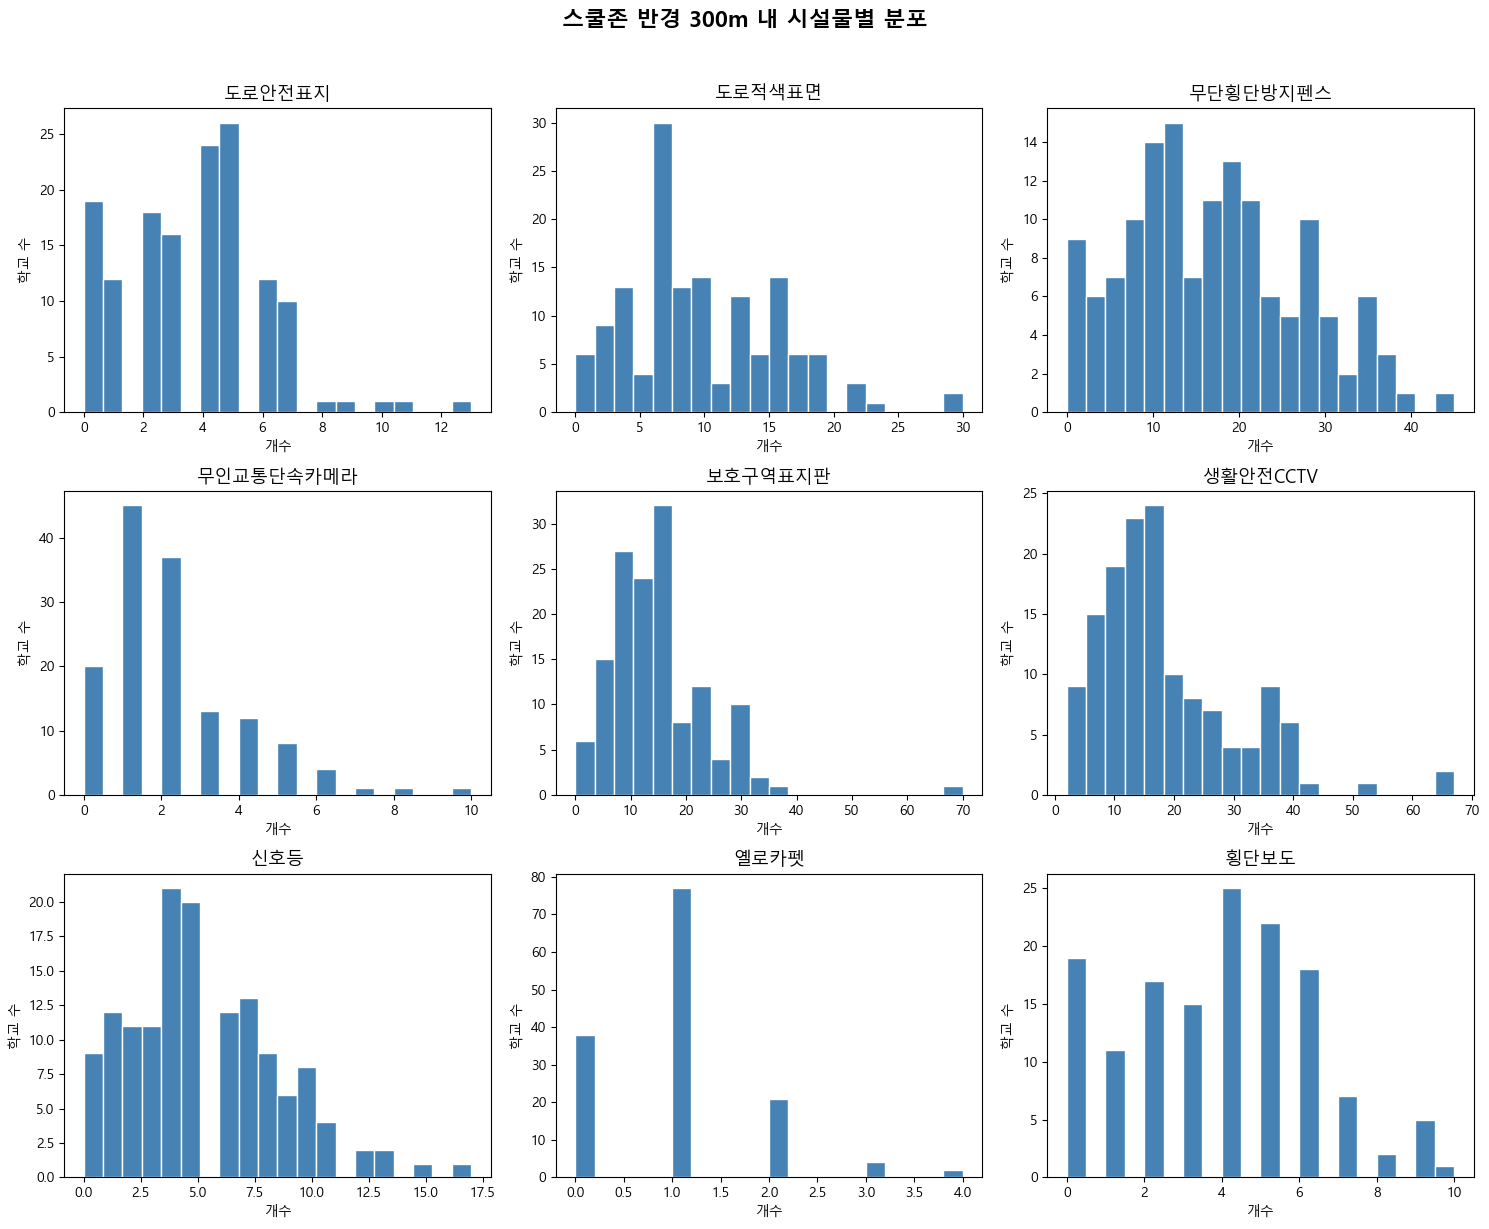

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# 시설물 컬럼만 추출
facility_cols = ['도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
                 '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(facility_cols):
    axes[i].hist(result_df[col], bins=20, color='steelblue', edgecolor='white')
    axes[i].set_title(col, fontsize=13)
    axes[i].set_xlabel('개수')
    axes[i].set_ylabel('학교 수')

plt.suptitle('스쿨존 반경 300m 내 시설물별 분포', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
accident.columns

Index(['대상시설명', '소재지지번주소', '위도_스쿨존', '경도_스쿨존', '사고지역위치명', '사고유형구분', '사고년도',
       '위도_사고', '경도_사고', '발생건수', '사상자수', '사망자수', '중상자수', '경상자수', '부상자수',
       '직선거리(m)'],
      dtype='object')

## 4) 행정구 매핑

해야할 것 
1. 학교가 어디 구인지 컬럼 추가
2. 해당구가 어린이 인구 통계에 있는지 확인 후 있다면 어린이인구통계데이터에 어린이 비율만 가져오기 


In [ ]:
# safetyzone_location.csv - 학교 위치 데이터
# facility_accident_data.csv - 시설물+사고 통합 데이터 (60개 학교)
safty_zone_location = pd.read_csv('../Raw-Data/스쿨존목록 및 안전시설물/성남/경기도_성남시_어린이보호구역_20251111.csv')
facility_accident = pd.read_csv('facilities_accident.csv')
child_population = pd.read_csv('./external_risk/어린이비율_행정동별.csv')

In [ ]:
child_population.head()

,구명,동명,총인구수,0~4세,5~9세,10~14세,어린이인구_0_14,어린이비율(%)
0,분당구,수내2동,10381,172,755,1125,2052,19.77
1,분당구,판교동,26365,1085,1499,2016,4600,17.45
2,분당구,운중동,38266,2013,2153,2153,6319,16.51
3,수정구,위례동,45473,1745,2348,2732,6825,15.01
4,중원구,금광1동,19608,1147,1079,622,2848,14.52


#### 카카오 지오코딩으로 스쿨존에 행정동 매핑

In [ ]:
import pandas as pd
import requests
import time
from dotenv import load_dotenv
import os

# -----------------------------------------------
# 카카오 REST API 키 설정
# -----------------------------------------------
load_dotenv()  
KAKAO_API_KEY = os.getenv("KAKAO_API_KEY")

def get_dong(lat, lng):
    """
    region_4depth_name이 비어있는 경우가 많아서
    region_3depth_name으로 변경합니다. (성남시 기준 여기에 동명이 들어있음)
    """
    session = requests.Session()
    session.headers.update({
        "Authorization": f"KakaoAK {KAKAO_API_KEY}",
        "Content-Type": "application/json; charset=utf-8"
    })
    
    url = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json"
    params = {"x": float(lng), "y": float(lat), "input_coord": "WGS84"}
    
    try:
        response = session.get(url, params=params)
        data = response.json()
        for doc in data.get("documents", []):
            if doc["region_type"] == "H":
                return doc["region_3depth_name"]  # ← 여기를 3depth로 수정
        return None
    except Exception as e:
        print(f"오류 ({lat}, {lng}): {e}")
        return None

# 루프 실행
dong_list = []
for idx, row in facility_accident.iterrows():
    dong = get_dong(row['위도'], row['경도'])
    dong_list.append(dong)
    print(f"[{idx+1}/60] {row['시설물명']} → {dong}")
    time.sleep(0.3)

facility_accident = facility_accident.copy()
facility_accident['행정동'] = dong_list

print(f"\n✅ 성공: {facility_accident['행정동'].notna().sum()}개")
print(f"❌ 실패: {facility_accident['행정동'].isna().sum()}개")

[1/60] 중원초등학교 → 상대원1동
[2/60] 중부초등학교 → 은행1동
[3/60] 구미초등학교 → 구미동
[4/60] 돌마초등학교 → 야탑2동
[5/60] 분당초등학교 → 서현1동
[6/60] 하탑초등학교 → 야탑2동
[7/60] 성남은행초등학교 → 은행2동
[8/60] 성남중앙초등학교 → 성남동
[9/60] 단남초등학교 → 금광1동
[10/60] 대원초등학교 → 상대원2동
[11/60] 대일초등학교 → 상대원3동
[12/60] 성남제일초등학교 → 중앙동
[13/60] 성남북초등학교 → 산성동
[14/60] 성남수정초등학교 → 수진2동
[15/60] 수진초등학교 → 태평3동
[16/60] 단대초등학교 → 단대동
[17/60] 금상초등학교 → 금광1동
[18/60] 상원초등학교 → 은행2동
[19/60] 서현초등학교 → 서현1동
[20/60] 안말초등학교 → 이매1동
[21/60] 야탑초등학교 → 야탑1동
[22/60] 이매초등학교 → 이매1동
[23/60] 수내초등학교 → 수내3동
[24/60] 성남동초등학교 → 금광2동
[25/60] 태평초등학교 → 태평3동
[26/60] 성수초등학교 → 수진2동
[27/60] 금빛초등학교 → 태평4동
[28/60] 성남초등학교 → 태평4동
[29/60] 중탑초등학교 → 야탑3동
[30/60] 초림초등학교 → 수내1동
[31/60] 미래유치원 → 산성동
[32/60] 성체유치원 → 수진1동
[33/60] 신흥성모유치원 → 신흥2동
[34/60] 은서유치원 → 태평3동
[35/60] 선경유치원 → 금광2동
[36/60] 예원유치원 → 성남동
[37/60] 다솜유치원 → 금광2동
[38/60] 아름다운유치원 → 수내3동
[39/60] 이솔유치원 → 금곡동
[40/60] 뽀뽀뽀유치원 → 야탑3동
[41/60] 꾸러기유치원 → 이매1동
[42/60] 즐거운유치원 → 금곡동
[43/60] 혜성유치원 → 금광1동
[44/60] 산성어린이집 → 산성동
[45/60] 성남어린이집 → 태평4동
[46/60] 성현어린이집 → 수진1동


#### 매핑 에러 해결

In [ ]:
import os
os.environ["PYTHONIOENCODING"] = "utf-8"

# 확인
import sys
print(sys.getdefaultencoding())   # utf-8
print(sys.stdout.encoding)        # utf-8

utf-8
UTF-8


In [ ]:
import requests


# 첫 번째 학교 한 개만 뽑아서 API 응답 원문을 그대로 출력합니다
row = facility_accident.iloc[0]

url = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json"
headers = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}
params = {"x": row['경도'], "y": row['위도'], "input_coord": "WGS84"}

response = requests.get(url, headers=headers, params=params)

print("HTTP 상태코드:", response.status_code)
print("응답 원문:")
print(response.json())

HTTP 상태코드: 200
응답 원문:
{'meta': {'total_count': 2}, 'documents': [{'region_type': 'B', 'code': '4113310500', 'address_name': '경기도 성남시 중원구 상대원동', 'region_1depth_name': '경기도', 'region_2depth_name': '성남시 중원구', 'region_3depth_name': '상대원동', 'region_4depth_name': '', 'x': 127.17407796734432, 'y': 37.442126733701976}, {'region_type': 'H', 'code': '4113357000', 'address_name': '경기도 성남시 중원구 상대원1동', 'region_1depth_name': '경기도', 'region_2depth_name': '성남시 중원구', 'region_3depth_name': '상대원1동', 'region_4depth_name': '', 'x': 127.16438100593076, 'y': 37.433238592559825}]}


#### 어린이 비율 매핑

In [ ]:
# facility_accident의 '행정동' ↔ child_population의 '동명' 으로 left join
# how='left'로 스쿨존 60개 기준을 유지합니다

df_merged = pd.merge(
    facility_accident,
    child_population,
    left_on='행정동',
    right_on='동명',
    how='left'
)

# 중복 컬럼 정리
df_merged = df_merged.drop(columns=['동명', '구명'])

# 결과 확인
print(f"전체 행 수: {len(df_merged)}")
print(f"인구 매핑 실패(NaN): {df_merged['어린이인구_0_14'].isna().sum()}개")
df_merged[['시설물명', '행정동', '어린이인구_0_14', '어린이비율(%)']].head(10)

전체 행 수: 60
인구 매핑 실패(NaN): 0개


,시설물명,행정동,어린이인구_0_14,어린이비율(%)
0,중원초등학교,상대원1동,1594,7.10
1,중부초등학교,은행1동,675,7.27
2,구미초등학교,구미동,2581,9.22
3,돌마초등학교,야탑2동,1762,11.32
4,분당초등학교,서현1동,3693,12.05
5,하탑초등학교,야탑2동,1762,11.32
6,성남은행초등학교,은행2동,1154,5.50
7,성남중앙초등학교,성남동,1633,5.13
8,단남초등학교,금광1동,2848,14.52
9,대원초등학교,상대원2동,182,6.25


In [ ]:
df = df_merged.copy()

In [ ]:
df_merged.drop(columns=['총인구수', '0~4세', '5~9세', '10~14세', '어린이인구_0_14'], inplace=True)
df_merged['어린이비율(%)'] = df_merged['어린이비율(%)'] * 0.01
df_merged.rename(columns={'어린이비율(%)': '어린이비율'}, inplace=True)

In [ ]:
df_merged.drop(columns=['사상자수', '사망및중상자수'], inplace=True)
df_merged.head()

,시설물명,위도,경도,도로안전표지,도로적색표면,무단횡단방지펜스,무인교통단속카메라,보호구역표지판,생활안전CCTV,신호등,옐로카펫,횡단보도,발생건수,행정동,어린이비율
0,중원초등학교,37.437855,127.167857,0,5,12,0,15,18,0,1,0,6,상대원1동,0.0710
1,중부초등학교,37.451546,127.164951,2,19,25,2,26,27,4,1,2,1,은행1동,0.0727
2,구미초등학교,37.337756,127.118398,6,17,27,1,30,5,17,1,6,6,구미동,0.0922
3,돌마초등학교,37.409099,127.130378,4,7,10,2,8,14,5,1,5,7,야탑2동,0.1132
4,분당초등학교,37.378988,127.129653,2,3,12,2,11,4,5,1,3,12,서현1동,0.1205


#### 결과 저장

In [ ]:
df_merged.to_csv('스쿨존_데이터.csv', index=False, encoding='utf-8-sig')

In [ ]:
df_merged.columns  

Index(['시설물명', '위도', '경도', '도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
       '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도', '발생건수', '행정동', '어린이비율'],
      dtype='object')

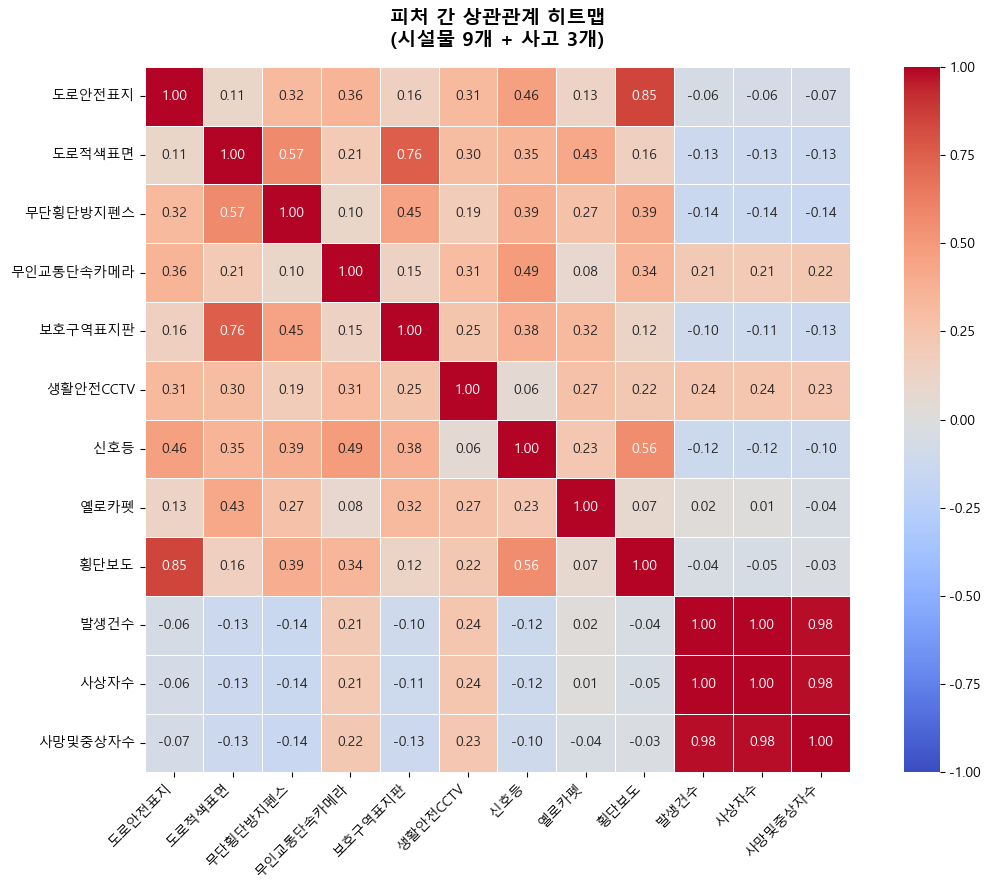

히트맵 저장: correlation_heatmap.png


In [10]:
import seaborn as sns

# ============================================================
# 피처 간 상관관계 히트맵
# ============================================================
# 왜 상관관계를 보나:
#   PCA 이전에 어떤 피처들이 서로 얼마나 겹치는지 확인
#   상관관계가 높은 피처들(예: 0.8 이상)은 사실상 같은 정보를 담고 있어서
#   PCA가 이걸 하나의 축으로 압축하는 근거가 됨

corr_matrix = df[cluster_features].corr()

fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    corr_matrix,
    annot=True,           # 각 셀에 수치 표시
    fmt=".2f",            # 소수점 2자리
    cmap="coolwarm",      # 양의 상관관계: 빨강, 음의 상관관계: 파랑
    center=0,             # 0 기준으로 색상 분기
    vmin=-1, vmax=1,      # 색상 범위 고정
    square=True,          # 셀을 정사각형으로
    linewidths=0.5,       # 셀 구분선
    ax=ax
)

ax.set_title("피처 간 상관관계 히트맵\n(시설물 9개 + 사고 3개)", fontsize=14, fontweight="bold", pad=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("히트맵 저장: correlation_heatmap.png")